En este notebook empleamos una estructura de circuito cuántico en la librería Pennylane para la clasificación de Iris, un dataset muy utilizado en ML. La estructura de este circuito se obtuvo del tutorial en la página de Pennylane (https://pennylane.ai/qml/demos/tutorial_variational_classifier.html) y esta inspirado en los papers de Fahri et al (https://arxiv.org/abs/1802.06002) y Schuld et al (https://arxiv.org/abs/1804.00633).


In [1]:
# importamos las librerías e instalamos aquellas que necesitemos
!pip install pennylane pennylane-sf pennylane-qiskit pennylane-cirq pennylane-forest pennylane-qsharp

import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, NesterovMomentumOptimizer, GradientDescentOptimizer

In [0]:
import matplotlib.pyplot as plt

Definimos el modelo a utilizar

In [0]:
# declaramos el entorno en el cual se va a correr el circuito en dos qubits del simulador de pennylane
dev = qml.device("default.qubit", wires=2)

In [0]:
# función que ayuda a la codificación de los inputs en el circuito (estamos siguiendo aplitude codification)
def get_angles(x):

    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(
        np.sqrt(x[2] ** 2 + x[3] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + x[2] ** 2 + x[3] ** 2)
    )

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])

# esta funcion nos ayuda a preparar el estado introducido, forma parte de la codificación por amplitud (protocolo muy utilizado en QML)
def statepreparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

# arquitectura básica del circuito, en este caso recibirá dos parámetros (matriz de pesos) del dataset
def layer(W):
    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.CNOT(wires=[0, 1])

In [0]:
# usamos el decorador para indicarle que es la funcion que compila el circuito (como vemos consta de la preparacion dle estado y luego aplica la capa tantas veces como filas tenga la matriz de pesos)
@qml.qnode(dev)
def circuit(weights, angles=None):
    statepreparation(angles)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

# en esta función cogemos los datos preprocesados por la funcion angles y alimentamos el circuito
def variational_classifier(var, angles=None):
    weights = var[0]
    bias = var[1]
    return circuit(weights, angles=angles) + bias

# funcion coste, estamos utilizando el error cuadrático medio
def cost(weights, features, labels):
    predictions = [variational_classifier(weights, angles=f) for f in features]
    return square_loss(labels, predictions)

In [0]:
# funcion de coste
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss
# funcion que nos da el accuracy
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

# **Primera parte: dataset Iris**

Ahora cargamos los datos, como solo utilizaremos dos features para clasificar dos de las clases necesitaremos un preprocesamiento de los datos. Luego, cargamos el dataset completo y nos quedamos solo con dos de las columnas y con dos de las clases.

In [0]:
# cargamos dataset de la plataforma sklearn
from sklearn.datasets import load_iris
from sklearn.preprocessing import Normalizer, StandardScaler

data = load_iris()
datos = data.data
target = data.target

# los escalamos 
# norm = Normalizer()
# norm.fit(datos)
# datos_normalizados = norm.transform(datos)

X = datos[:100, :]



target = target[target < 2]
Y = []
for tar in target:

  if tar == 1:
    Y.append(1)
  else:
    Y.append(-1)

Y = np.asarray(Y)

In [8]:
print("Primera entrada X (original)  :", X[0])

# pad the vectors to size 6 with constant values
padding = 0.3 * np.ones((len(X), 1))
X_pad = np.c_[np.c_[X, padding], np.zeros((len(X), 1))]
print("Primera entrada X (padded)    :", X_pad[0])

# normalize each input
normalization = np.sqrt(np.sum(X_pad ** 2, -1))
X_norm = (X_pad.T / normalization).T
print("Primera entrada X (normalized):", X_norm[0])

# angles for state preparation are new features
features = np.array([get_angles(x) for x in X_norm])
print("Primeros atributos de entrada      :", features[0])

Primera entrada X (original)  : [5.1 3.5 1.4 0.2]
Primera entrada X (padded)    : [5.1 3.5 1.4 0.2 0.3 0. ]
Primera entrada X (normalized): [0.80287587 0.55099325 0.2203973  0.03148533 0.04722799 0.        ]
Primeros atributos de entrada      : [ 0.44954297 -0.14189705  0.14189705 -0.60145471  0.60145471]


In [0]:
X.shape, Y.shape

((100, 4), (100,))

Una vez retocados los datos de iris vamos a visualizarlos para ver lo que generamos

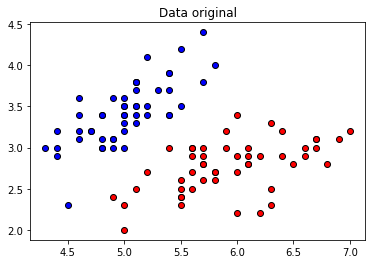

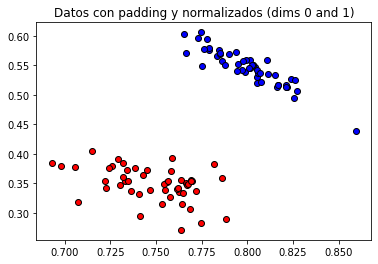

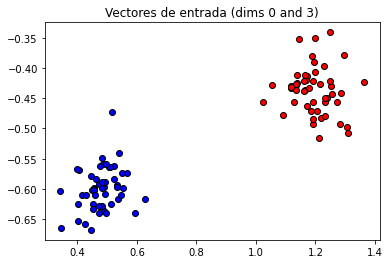

In [0]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="r", marker="o", edgecolors="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="b", marker="o", edgecolors="k")
plt.title("Data original")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="r", marker="o", edgecolors="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="b", marker="o", edgecolors="k")
plt.title("Datos con padding y normalizados (dims {} and {})".format(dim1, dim2))
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="r", marker="o", edgecolors="k")
plt.scatter(
    features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="b", marker="o", edgecolors="k"
)
plt.title("Vectores de entrada (dims {} and {})".format(dim1, dim2))
plt.show()


In [0]:
# separamos en train y validation
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# util para graficar los resultados obtenidos
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

Vamos a entrenar el modelo

In [0]:
# hiperparametros 
num_qubits = 2
num_layers = 8
var_init = (0.01 * np.random.randn(num_layers, num_qubits, 3), 0.0) # pesos iniciales

In [0]:
opt = AdamOptimizer(0.01)
batch_size = 5

# train the variational classifier
var = var_init
for it in range(80):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

    # Compute predictions on train and validation set
    predictions_train = [np.sign(variational_classifier(var, angles=f)) for f in feats_train]
    predictions_val = [np.sign(variational_classifier(var, angles=f)) for f in feats_val]

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
        "".format(it + 1, cost(var, features, Y), acc_train, acc_val)
    )

Iter:     1 | Cost: 1.9551164 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     2 | Cost: 1.9341837 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     3 | Cost: 1.9151255 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     4 | Cost: 1.8960264 | Acc train: 0.4800000 | Acc validation: 0.5600000 
Iter:     5 | Cost: 1.8827322 | Acc train: 0.4800000 | Acc validation: 0.5200000 
Iter:     6 | Cost: 1.8715120 | Acc train: 0.4666667 | Acc validation: 0.4800000 
Iter:     7 | Cost: 1.8585527 | Acc train: 0.4266667 | Acc validation: 0.4400000 
Iter:     8 | Cost: 1.8475628 | Acc train: 0.3600000 | Acc validation: 0.4000000 
Iter:     9 | Cost: 1.8353897 | Acc train: 0.2933333 | Acc validation: 0.3200000 
Iter:    10 | Cost: 1.8229429 | Acc train: 0.1333333 | Acc validation: 0.1200000 
Iter:    11 | Cost: 1.8117418 | Acc train: 0.0266667 | Acc validation: 0.0400000 
Iter:    12 | Cost: 1.8025935 | Acc train: 0.0266667 | Acc validation: 0.0000000 
Iter:    13 | Co

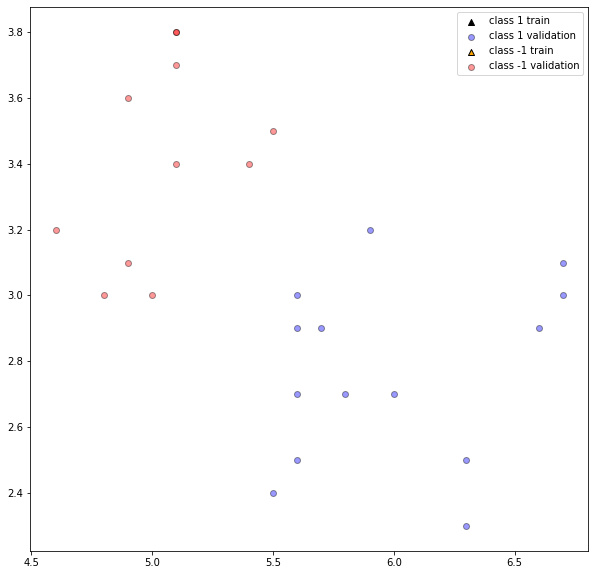

In [0]:
# ploteamos resultados
plt.figure(figsize=(10,10))

# plot data
plt.scatter(
    X_val[:, 0][predictions_val == 1],
    X_val[:, 1][predictions_val == 1],
    c="black",
    marker="^",
    edgecolors="k",
    label="class 1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == 1],
    X_val[:, 1][Y_val == 1],
    c="b",
    marker="o",
    alpha = .4,
    edgecolors="k",
    label="class 1 validation",
)
plt.scatter(
    X_val[:, 0][predictions_val == -1],
    X_val[:, 1][predictions_val == -1],
    c="orange",
    marker="^",
    edgecolors="k",
    label="class -1 train",
)
plt.scatter(
    X_val[:, 0][Y_val == -1],
    X_val[:, 1][Y_val == -1],
    c="r",
    marker="o",
    alpha = .4,
    edgecolors="k",
    label="class -1 validation",
)

plt.legend()
plt.show()

# Simulaciones cross val

In [12]:
np.random.seed(123)
num_data = len(Y)
num_train = int(0.75 * num_data)
index1 = np.random.permutation(range(num_data))
index2 = np.random.permutation(range(num_data))
index3 = np.random.permutation(range(num_data))

indexes = [index1, index2, index3]
counter = 0

opt = AdamOptimizer(0.01)
batch_size = 5

for index in indexes:
  feats_train = features[index[:num_train]]
  Y_train = Y[index[:num_train]]
  feats_val = features[index[num_train:]]
  Y_val = Y[index[num_train:]]

  # util para graficar los resultados obtenidos
  X_train = X[index[:num_train]]
  X_val = X[index[num_train:]]

  var = var_init
  for it in range(80):

      # Update the weights by one optimizer step
      batch_index = np.random.randint(0, num_train, (batch_size,))
      feats_train_batch = feats_train[batch_index]
      Y_train_batch = Y_train[batch_index]
      var = opt.step(lambda v: cost(v, feats_train_batch, Y_train_batch), var)

      # Compute predictions on train and validation set
      predictions_train = [np.sign(variational_classifier(var, angles=f)) for f in feats_train]
      predictions_val = [np.sign(variational_classifier(var, angles=f)) for f in feats_val]

      # Compute accuracy on train and validation set
      acc_train = accuracy(Y_train, predictions_train)
      acc_val = accuracy(Y_val, predictions_val)

      print(
          "Fold: {} | Iter: {:5d} | Cost: {:0.7f} | Acc train: {:0.7f} | Acc validation: {:0.7f} "
          "".format(counter + 1, it + 1, cost(var, features, Y), acc_train, acc_val))
  counter += 1

Fold: 1 | Iter:     1 | Cost: 1.9542149 | Acc train: 0.4666667 | Acc validation: 0.6000000 
Fold: 1 | Iter:     2 | Cost: 1.9318831 | Acc train: 0.4666667 | Acc validation: 0.6000000 
Fold: 1 | Iter:     3 | Cost: 1.9138363 | Acc train: 0.4666667 | Acc validation: 0.6000000 
Fold: 1 | Iter:     4 | Cost: 1.8952477 | Acc train: 0.4666667 | Acc validation: 0.5600000 
Fold: 1 | Iter:     5 | Cost: 1.8795774 | Acc train: 0.4666667 | Acc validation: 0.5600000 
Fold: 1 | Iter:     6 | Cost: 1.8664578 | Acc train: 0.4266667 | Acc validation: 0.5200000 
Fold: 1 | Iter:     7 | Cost: 1.8534016 | Acc train: 0.4000000 | Acc validation: 0.4800000 
Fold: 1 | Iter:     8 | Cost: 1.8393008 | Acc train: 0.2933333 | Acc validation: 0.3600000 
Fold: 1 | Iter:     9 | Cost: 1.8272932 | Acc train: 0.2000000 | Acc validation: 0.2000000 
Fold: 1 | Iter:    10 | Cost: 1.8145915 | Acc train: 0.1466667 | Acc validation: 0.0800000 
Fold: 1 | Iter:    11 | Cost: 1.8038607 | Acc train: 0.0266667 | Acc validation: